In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime, timedelta
import seaborn as sns

# the gust file location
xls_file = 'new_date_data.xlsx'

# letting you see the sheet names of the excel file
xl = pd.ExcelFile(xls_file)
print (xl.sheet_names)

# putting the excile file for that specific sheet (Sheet2) into pandas dataframe
# making the 'dates' into datetime object
# turning 'dates' into index of dataframe
# only keeping the 'Start Time' column
gust = pd.DataFrame(pd.read_excel(xls_file, parse_dates=['dates'],index_col='dates')['Start Time'])

# filling all 'NaN' s with 0
gust.fillna(0, inplace=True)

# hardcoding fixing the value 'afternoon' with 1200 to be actually noon
# gust.replace(to_replace='afternoon', value=1200, inplace=True)

# fixing the timestamp

# giving leading zeros to timestamp
gust['Fixed Time'] = ["{0:0>4}".format(x) for x in gust['Start Time']]

# turning it to 1-12 instead of 1-24 times
# gust['Fixed Time'] = ["{}:{}".format(str(int(x[:2])%12), x[2:]) for x in gust['Fixed Time']]

# giving leading zeros to timestamp
gust['Fixed Time'] = ["{0:0>4}".format(x) for x in gust['Fixed Time']]

# only keeping the date from the date column and keeping the time from the fixed times column
gust['Time'] = ['{} {}'.format(str(gust.index[i])[:10], gust['Fixed Time'].iloc[i]) for i in range(len(gust))]

# turning the time column into datetime object
gust['Time'] = pd.to_datetime(gust['Time'], format='%Y-%m-%d %H:%M')

# only keeping time column
gust = gust['Time']

print (gust.head(100))

[u'Sheet1']
dates
2011-05-31   2011-05-31 08:41:00
2011-06-12   2011-06-12 04:49:00
2011-06-16   2011-06-16 07:45:00
2011-07-02   2011-07-02 21:00:00
2011-07-03   2011-07-03 22:50:00
2011-07-13   2011-07-13 03:15:00
2011-08-04   2011-08-04 09:58:00
2011-08-10   2011-08-10 11:15:00
2011-08-19   2011-08-19 10:06:00
2011-08-20   2011-08-20 07:27:00
2012-05-01   2012-05-01 03:12:00
2012-05-07   2012-05-07 02:25:00
2012-05-31   2012-05-31 02:51:00
2012-06-03   2012-06-03 07:10:00
2012-06-16   2012-06-16 11:44:00
2012-07-14   2012-07-14 06:38:00
2012-08-04   2012-08-04 07:25:00
2012-08-08   2012-08-08 01:31:00
2012-08-16   2012-08-16 12:15:00
2012-08-18   2012-08-18 13:45:00
2013-05-01   2013-05-01 21:13:00
2013-05-09   2013-05-09 06:50:00
2013-05-15   2013-05-15 20:08:00
2013-05-31   2013-05-31 23:20:00
2013-06-05   2013-06-05 08:08:00
2013-06-15   2013-06-15 18:37:00
2013-06-17   2013-06-17 06:09:00
2013-07-10   2013-07-10 05:47:00
2013-07-21   2013-07-21 01:30:00
2013-07-23   2013-07-23 0

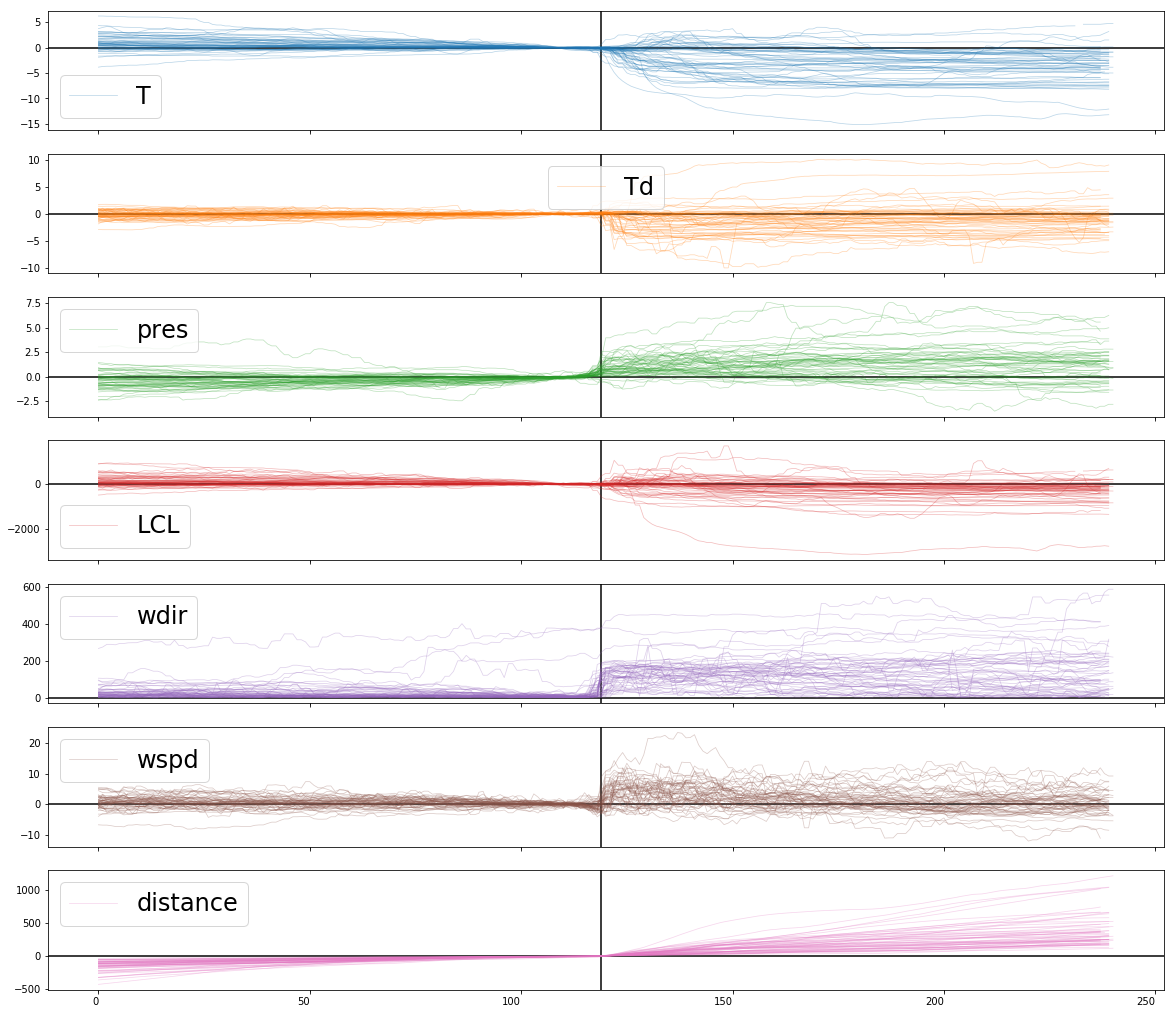

In [57]:
# !pip install netcdf
file_name = 'ARM_E13_surface_met_new.nc'

# opening the filetpe with the xarray package
data = xr.open_dataset(file_name)

# turning it to pandas dataframe
df = data.to_dataframe()

# fixing the weird timestamp issue
# was in nanoseconds so multiplied by 10**9 to turn to seconds as we expected
df['date'] = pd.to_datetime(df['timeUNIX']*10**9)

# turning 'date' column into index
df.index = df['date']

# only keep these specific columns in our dataframe
df = df[['T','Td','pres','LCL','wdir','wspd']]

# the time window that we want to look backwards and forward 
deltaT = timedelta(hours=1)

gust_fronts = []

# df['distance'] = df.iloc[:,5].cumsum()

for n, date in enumerate(gust):
    # the plot start and end time from gust data
    start_time = (date - 2*deltaT) 
    end_time = (date + 2*deltaT)

#     print (start_time)
#     print (end_time)

    # plot the dataframe from the timestamps starttime and endtime
    # .loc allows you to slice based off of the datetime index we used for out dataframe
    # .iloc would let you index by the index value, i.e. [0:4] to get first 4 vals
    gust_front = df.loc[start_time:end_time].resample('T').bfill()


    # this subtracts the 20 min avg prior to the start time
    gust_front.iloc[:,0] -= gust_front.iloc[len(gust_front)//2-20:len(gust_front)//2, 0].mean() 
    gust_front.iloc[:,1] -= gust_front.iloc[len(gust_front)//2-20:len(gust_front)//2, 1].mean()
    gust_front.iloc[:,2] -= gust_front.iloc[len(gust_front)//2-20:len(gust_front)//2, 2].mean()
    gust_front.iloc[:,3] -= gust_front.iloc[len(gust_front)//2-20:len(gust_front)//2, 3].mean()
    gust_front.iloc[:,4] -= gust_front.iloc[len(gust_front)//2-20:len(gust_front)//2, 4].mean()
    
    gust_front.iloc[:,5] -= gust_front.iloc[len(gust_front)//2-20:len(gust_front)//2, 5].mean()

    gust_front['distance'] = gust_front.iloc[:,5].abs().expanding().sum()
    
    
    gust_front.iloc[:,4] = np.degrees(np.unwrap(np.radians(gust_front.iloc[:,4])))
    gust_front.iloc[:,4] = gust_front.iloc[:,4].abs()
    gust_front.iloc[:,6] -= gust_front.iloc[len(gust_front)//2, 6]

#     print(avg_windspeed)
    
    gust_fronts.append(gust_front)

ax = gust_fronts[0].reset_index(drop=True).plot(subplots=True, alpha=0.3, figsize=(20,20), lw=.75 )#,fontsize=24)
for axes in ax:
    axes.legend(fontsize=24)
    
    
# plt.xticks(range(-1,120,5),range(-60,60,5))
for subplot in ax:
    subplot.axvline(x=len(gust_front)//2,color='k')
    subplot.axhline(y=0,color='k')


for df in gust_fronts[1:]:
    ax2 = df.reset_index(drop=True).plot(ax=ax,subplots=True, alpha=0.3, legend=False, lw=.75) 
#     plt.xticks(range(-1,120,5),range(-60,60,5))

# shape = min([df.shape[0] for df in gust_fronts])

# totals = np.zeros([shape,6])

# for df in gust_fronts:
#     totals += df.iloc[:shape].reset_index(drop=True).values
       
# totals /= len(gust_fronts)
# totals = pd.DataFrame(totals, columns=gust_front.columns)

# totals.plot(ax=ax, subplots=True, alpha=1,lw=1.5, legend=False)
# plt.tight_layout()
# plt.legend(df.columns,fontsize=24)
# plt.show()
# print(gust_fronts)
# plt.savefig('Gust_plots/' + 'avgplot_wind' + '.png')
# print(gust_front["unit_time"])
# plt.clf()


# for g in gust_fronts:
#     g['unit_time'].plot(title=g.index.values[len(g)//2], figsize=(6,2))
#     plt.savefig('UnitTimePlots/{}.jpeg'.format(str(g.index.values[len(g)//2]).replace(':','-')))
#     plt.show()
# print(df.iloc[:,5])

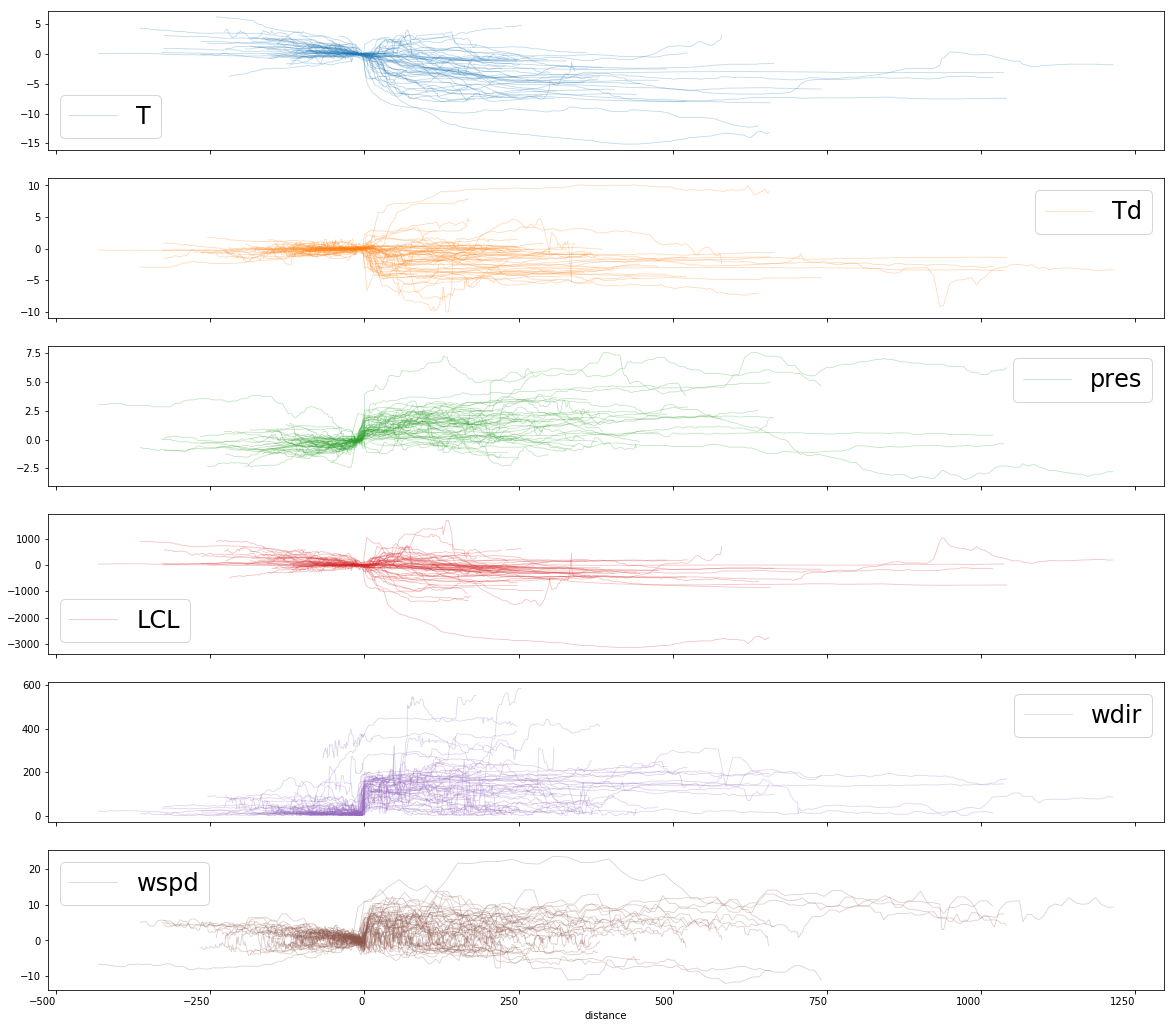

In [58]:
ax = gust_fronts[0].plot(x='distance', subplots=True, figsize=(20,20), alpha=0.3, lw=0.75)
for axes in ax:
    axes.legend(fontsize=24)

for gust_front in gust_fronts[1:]:
    gust_front.plot(x='distance', subplots=True, alpha=0.3, lw=0.75, legend=False, ax=ax)
    



plt.show()